# Imports


In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from libcpab.libcpab.pytorch import cpab
from libcpab.libcpab.helper.utility import show_images
from PIL import Image
from sklearn.metrics import accuracy_score
import pylab as pl
from IPython import display
from skimage.transform import resize
import datetime

----------------------------------------------------------------------
Operating system: darwin
Using pytorch backend
----------------------------------------------------------------------


# Construct Dataset

In [3]:
class FineGrainedDataset(Dataset):
    
    def __init__(self, csv_path, picture_path, picturesize, transform=True):
        """
        Construct Fine Grained Dataset.
        
        Args
            csv_path: Path to CSV file.
            picturesize: Dimensions of sample images.
            transform: 
        """
        self.transform = transform
        self.picturesize = picturesize
        
        # construct dataframe with onehot notation
        self.df = pd.get_dummies(pd.read_csv(csv_path))
        # create ID column with image file names
        self.df['id'] = self.df['image_id'].apply(lambda x: str(x)) + "_" + self.df['tag_id'].apply(lambda x: str(x)) + ".png"
        # only use class columns and id column
        self.df = self.df.iloc[:, 10:]
        self.df = self.df.replace(to_replace=-1, value=0)
        self.df['id'] = self.df['id'].astype(str)
        
        self.path = picture_path
            
        
    def __getitem__(self, idx):
        """
        Support integer indexing on dataset (range 0 to len(self)).
        """
        sample_id = self.df['id'].iloc[idx]
        
        # get target values for sample
        targets = self.df.loc[idx, self.df.columns != 'id'].values.astype('float32')
        
        # get sample image
        image = np.asarray(Image.open(self.path + sample_id))
        
        # transform sample
        if self.transform:
            img = image
            img_normalized = np.copy(img)
            img_normalized = img_normalized / 255.
            
            img_resized = resize(img_normalized, output_shape=(self.picturesize,self.picturesize), mode='reflect', anti_aliasing=True)[:,:,:3]
            
            sample = {'id': sample_id, 'targets': torch.from_numpy(targets), 'image': torch.from_numpy(img_resized)}
        else:
            sample = {'id': sample_id, 'targets': targets, 'image': image}
        
        return sample
    
    def __len__(self):
        """
        Get length of dataset.
        """
        return len(self.df)
    

# Load Dataset

In [4]:
dataset = FineGrainedDataset(csv_path='./data/dataset_v2/train.csv',
                             picture_path='./data/dataset_v2/training_imagery/cropped/', 
                             picturesize=224, 
                             transform=True)
dataset.df.head()

,sunroof,luggage_carrier,open_cargo_area,enclosed_cab,spare_wheel,wrecked,flatbed,ladder,enclosed_box,soft_shell_box,...,sub_class_van,color_black,color_blue,color_green,color_other,color_red,color_silver/grey,color_white,color_yellow,id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,16490_15036.png
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,16490_31658.png
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,17122_26971.png
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12193_19301.png
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,12193_35906.png


# Check Class Imbalance
We count the number of positive (one) occurrences in each class to see the representation of the classes in the dataset.

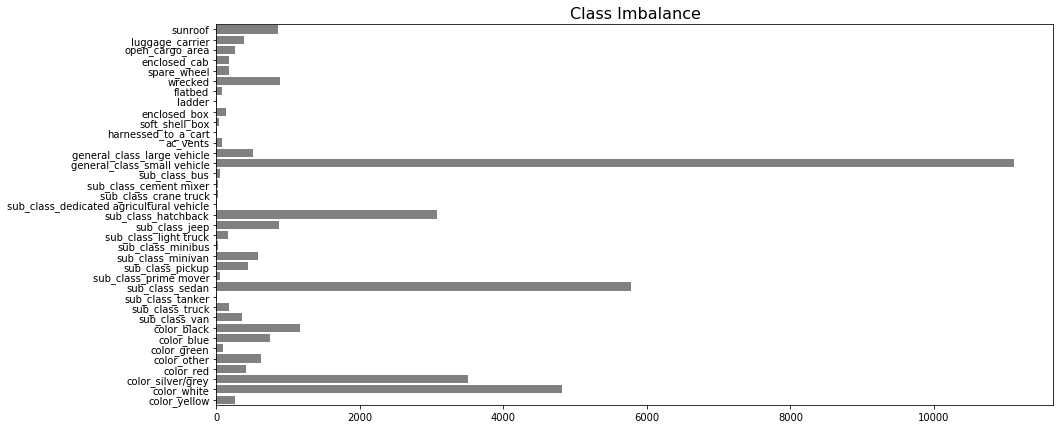

In [5]:
counts = dataset.df.drop(columns=['id'], inplace=False).sum(axis=0)

plt.figure(figsize=(15,7))
sns.barplot(x=counts.values, y=counts.index.values, color='grey')
plt.title('Class Imbalance', fontsize=16)
plt.show()

# Create Training-validation Split
This function creates a split for the dataset, splitting it in a training partition and a validation partition. The split is created with respect to class imbalance, which means that the lowest represented class is first splitted.
While iterating over all classes to the highest represented class, the pools of samples to draw from will vary in size, this is beacause samples that are already drawn from the draw of a lower represented class, are not a part of the current pool of samples. Therefore at each class split the number of samples that are a part of the current class and which are already drawn, is calculated and withdrawn from the total number of samples in the class. The remaining pool of samples are then split in a training partition and a validation partition.

In [6]:
def train_valid_split(df, trainsplit_size=0.8):
    """
    Split a dataset in training- and validation split.

    Split is made by splitting the least represented class first
    and the highest represented class last.

    Function is made for multilabel problems where samples that are already 
    drawn from a previous class are not drawn again, and the ratio of the 
    split is calculated at each class from the previous draws to match the 
    split criteria.

    Args
        df: A dataframe which the split should be created from.
            The indexes should be the ID's of the samples.
        trainsplit_size: The size of the training split. 
                         Should be a float in the interval [0, 1]
    """
    # placeholders
    cls = {}
    train_idx = []
    valid_idx = []
    
    df_cls = df.loc[:, df.columns != 'id']

    # get number of occurrences for each class
    for col in df_cls:
        size = len(df_cls.loc[df_cls[col] == 1])
        cls[col] = size

    # sort classes by ascending
    cls_sorted = sorted(cls.items(), key=lambda value: value[1])

    # iterate over classes from least represented class
    # and draw samples for training- and validation split
    for col in cls_sorted:
        # get indexes for samples where class value is 1
        indexes = df_cls.loc[df_cls[col[0]] == 1].index

        # Remove indexes that already are appended to test_idx array
        indexes = [indexes[i] for i in range(len(indexes)) if indexes[i] not in valid_idx and indexes[i] not in train_idx]

        # get size of how many indexes should be drawn for train
        train_size = int(len(indexes) * trainsplit_size)

        # get indexes for train- and validation split
        idx_train = [indexes[i] for i in sorted(random.sample(range(len(indexes)), train_size))]
        idx_valid = [indexes[i] for i in range(len(indexes)) if indexes[i] not in idx_train]

        # save indexes
        train_idx.extend(idx_train)
        valid_idx.extend(idx_valid)
        
    print("Number of samples in provided dataset: {}\n".format(len(df_cls)))
    print("Split criteria\ntrain size: {:.2f} %\nvalid size: {:.2f} %".format(trainsplit_size*100, 
                                                                   (1-trainsplit_size)*100))
    print("\nSplit results")
    print("Train size:\t{}\t({:.2f} %)".format(len(train_idx), \
                                               (len(train_idx) / len(df_cls)) * 100))
    print("Val size:\t{}\t({:.2f} %)".format(len(valid_idx), \
                                     (len(valid_idx) / len(df_cls)) * 100))

    return train_idx, valid_idx

In [7]:
train_indexes, valid_indexes = train_valid_split(dataset.df, trainsplit_size=0.8)

Number of samples in provided dataset: 11617

Split criteria
train size: 80.00 %
valid size: 20.00 %

Split results
Train size:	9281	(79.89 %)
Val size:	2336	(20.11 %)


# Define Dataloader

In [8]:
BATCH_SIZE = 64

trainsampler = SubsetRandomSampler(train_indexes)
validsampler = SubsetRandomSampler(valid_indexes)

samplers = {'train': trainsampler,
            'valid': validsampler}

trainloader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         sampler=samplers['train'],
                         num_workers=4)
validloader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         sampler=samplers['valid'],
                         num_workers=4)

dataloaders = {'train': trainloader,
               'valid': validloader}

dataset_sizes = {x: len(samplers[x]) for x in ['train', 'valid']}

## Score Metric
The score we will evaluate our model by, will be the mean average precision (MAP) score. 

In [9]:
def calculate_precision(pred, true):
    K = dataset.df.shape[1]-1
    predicted_positives = (np.array(pred) == 1).sum()
    
    ### HER ER DER TO TRUE POSITIVES? ####
    true_positives = np.array([a == b and a == 1 for a, b in zip(pred, true)])
    true_positives = (np.array(true_positives) == 1).sum()
    ### SNAK MED BILL ###
    
    result = true_positives / predicted_positives
    
    return result

def AP(pred, true):
    K = dataset.df.shape[1]-1
    precision = calculate_precision(pred, true)
    a = np.array([a == b and a == 1 for a, b in zip(pred, true)])
    score = (np.array(a) ==True).sum() * precision
    
    result = score / K
    
    return result



def MAP(predicted_data, true_data):
    K = dataset.df.shape[1]-1
    result = np.array([AP(pred, true) for pred, true in zip(predicted_data, true_data)]).sum() / K

    return result

# Define neural network
## Prepare pretrained resnet

In [10]:
#define the model
model_conv = models.resnet50(pretrained='imagenet')

# disable autograd for resnet
for param in model_conv.parameters():
    param.requires_grad = False
    
# Change fully connected layer to match paper (autograd is default on new layers)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 1024)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

## Define neural network

In [11]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        # input layer
        output_nodes = dataset.df.shape[1]-1
        self.output = nn.Linear(1024,output_nodes)
       

    def forward(self, x):
        x = model_conv(x)
        x = F.relu(x)
        x = self.output(x)
        x = torch.sigmoid(x)
        return x


net = Net().to(device)




# Train

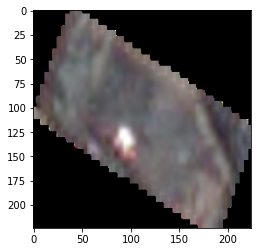

prediction was ['general_class_small vehicle']
label was ['wrecked', 'general_class_small vehicle', 'sub_class_sedan', 'color_red']


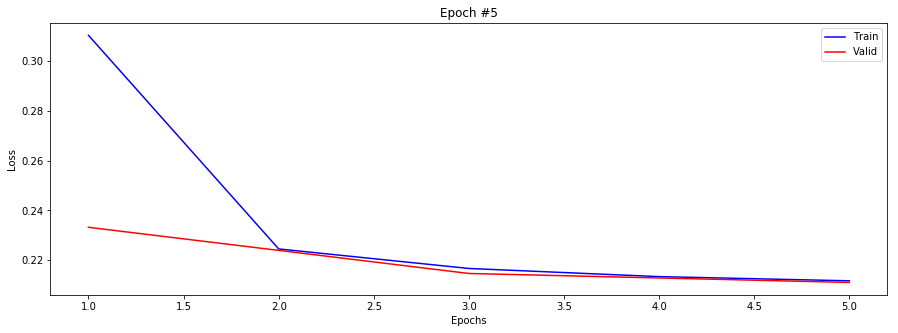

Training loss: 0.21
Validation loss:0.21	Validation MAP: 1.89

					Training time 0:05:32.530736


In [11]:
%matplotlib inline
epochs = 5
threshold = 0.5
valid_every = 2
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


losses_train = pd.DataFrame(columns=['Epoch','Loss'])
losses_valid = pd.DataFrame(columns=['Epoch','Loss'])

now = datetime.datetime.now()
picUpdate = datetime.datetime.now()

print("Using device:", device)

for epoch in range(epochs):
    batch_loss = []
   
    net.train()
    for batch in dataloaders['train']:
        inputs = batch['image'].permute(0, 3, 1, 2)
        labels = batch['targets']
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # make prediction, and do loss / backporopgation
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        
        #################### plotting ###############################
        if epoch > 0:
            if datetime.datetime.now() > picUpdate:
                pred = [dataset.df.columns[i] for i,pred in enumerate(output[0]) if pred > threshold]
                label = [dataset.df.columns[i] for i,pred in enumerate(labels[0]) if pred > threshold]
                img = inputs[0].cpu().numpy().transpose((1, -1, 0)) #transpose(1,-1,0)
                pl.imshow(img);
                pl.show()
                print("prediction was {}".format(pred))
                print("label was {}".format(label))
                picUpdate = datetime.datetime.now() + datetime.timedelta(seconds=1)
                # Plot the loss every epoch
                pl.figure(figsize=(15,5))
                pl.xlabel('Epochs')
                pl.ylabel('Loss')
                pl.title('Epoch #{}'.format(epoch+1))
                pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
                pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
                pl.legend()
                pl.show()
                print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
                print('Validation loss:{:.2f}\tValidation MAP: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy))
                display.clear_output(wait=True)
            
        else:
            if datetime.datetime.now() > picUpdate:
                pred = [dataset.df.columns[i] for i,pred in enumerate(output[0]) if pred > threshold]
                label = [dataset.df.columns[i] for i,pred in enumerate(labels[0]) if pred > threshold]
                img = inputs[0].cpu().numpy().transpose((1, -1, 0)) #transpose(1,-1,0)
                pl.imshow(img);
                pl.show()
                print("prediction was {}".format(pred))
                print("label was {}".format(label))
                picUpdate = datetime.datetime.now() + datetime.timedelta(seconds=1)
                display.clear_output(wait=True)
        #############################################################              
        
       
    losses_train.loc[epoch] = [epoch+1,np.mean(batch_loss)]
    
    if epoch%valid_every == 0 or epoch == max(range(epochs)):
        batch_loss = []
        preds = np.empty((0,37), int)
        trues = np.empty((0,37), int)
        net.eval()
        for batch in dataloaders['valid']:
            inputs = batch['image'].permute(0, 3, 1, 2)
            labels = batch['targets']
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float) 
            
            # Make prediction
            output = net(inputs)
            loss = criterion(output,labels)
            batch_loss.append(loss.item())
            
            # Append values for later calculation of accuracy
            preds = np.append(preds,[[1 if pred > threshold else 0 for pred in sample] for sample in output], axis=0)
            trues = np.append(trues,[[1 if pred > threshold else 0 for pred in sample] for sample in labels.tolist()], axis=0)
            
            
        
        losses_valid.loc[epoch] = [epoch+1,np.mean(batch_loss)]
        accuracy = MAP(preds, trues)
    
    
    #################### plotting ###############################
    pl.imshow(img);
    pl.show()
    print("prediction was {}".format(pred))
    print("label was {}".format(label))
    # Plot the loss every epoch
    pl.figure(figsize=(15,5))
    pl.xlabel('Epochs')
    pl.ylabel('Loss')
    pl.title('Epoch #{}'.format(epoch+1))
    pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
    pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
    pl.legend()
    pl.show()
    print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
    print('Validation loss:{:.2f}\tValidation MAP: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy))
    display.clear_output(wait=True)
    #############################################################

#################### plotting ###############################    
pl.imshow(img);
pl.show()
print("prediction was {}".format(pred))
print("label was {}".format(label))    
# Final plot    
pl.figure(figsize=(15,5))
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.title('Epoch #{}'.format(epoch+1))
pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
pl.legend()
pl.show()

print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
print('Validation loss:{:.2f}\tValidation MAP: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy))

print("\n\t\t\t\t\tTraining time {}".format(datetime.datetime.now()-now))
#############################################################

# Augment Data
We will generate augmented data taking class imbalance into consideration. 

### Calculate Number of Augmented Samples to Generate
First we will calculate the number of times each sample is to be augmented.

In [12]:
def calculateAugmentation(df, criteria=1000, restriction=10):
    """
    Calculate how many times a sample is to be upsampled with augmentation
    compared to the represantation of its class or if multilabel, its classes.

    Be aware of samples of a low represented class can be part of a larger class also.
    The aforementioned can result in upsampling of high represented classes as well,
    when upsampling low represented classes.

    Args
        df: A dataframe which the upsampling size is calculated from.
            The indexes should be the ID's of the samples.
        criteria: The criteria to match number of times to upsample a class with.
    """
    # placeholders
    classes = {}
    samplesToAugment = {}

    # get number of occurrences for each class
    for column in [column for column in df.columns if column != 'id']:
        num_occ = len(df.loc[df[column] == 1])
        classes[column] = num_occ

    # sort classes by ascending size
    classes_sorted = sorted(classes.items(), key=lambda value: value[1])
    
    # iterate over classes and calculate
    # number of times to augment data to
    # match specified criteria
    for cls in classes_sorted:
        # get id for samples where class value is 1
        indexesInClass = df.loc[df[cls[0]] == 1]['id'].tolist()

        # remove indexes that already are appended to samplesToAugment
        indexesToAugment = [indexesInClass[i] for i in range(len(indexesInClass)) \
                            if indexesInClass[i] not in samplesToAugment.keys()]

        # find how many times already is upsampled
        already_size = sum([samplesToAugment.get(sample) for sample in indexesInClass \
                            if sample in samplesToAugment.keys() and sample not in indexesToAugment])

        # calculate number of times samples in class 
        # should be upsampled to match specified criteria
        if len(indexesToAugment) == 0:
            augment_size = int(1000 - already_size)
        # split upsample size over all samples to augment
        else:
            augment_size = int((1000-already_size) / len(indexesToAugment))

        # respect restriction criteria
        if augment_size > restriction:
            augment_size = 10
        # if class is already upsampled enough
        # do not upsample remaining samples in class
        elif augment_size < 0:
            augment_size = 0

        # save ID name of sample indexes to augment and corresponding number of times to upsample
        for index in indexesToAugment:
            if index in samplesToAugment.keys():
                print("Index already in samplesToAugment, overwriting key..")
            samplesToAugment[index] = augment_size

    return samplesToAugment

In [13]:
num_augment_samples = calculateAugmentation(df=dataset.df)

# show 10 first samples
print("ID\tNumber of times to augment")
display.display({k: num_augment_samples[k] for k in list(num_augment_samples)[:10]})

# total number of generated augmented samples
total_augmented = sum([value for value in num_augment_samples.values()])
print("Total number of augmented samples that will be generated: ", total_augmented)
print("Size of dataset after augmentation will be {} samples".format(len(dataset.df) + total_augmented))

ID	Number of times to augment


{'12599_23360.png': 10,
 '19725_11495.png': 10,
 '13748_23885.png': 10,
 '13748_20345.png': 10,
 '16917_16874.png': 10,
 '18420_13560.png': 10,
 '15320_11975.png': 10,
 '18860_23851.png': 10,
 '19725_24690.png': 10,
 '19531_26689.png': 10}

Total number of augmented samples that will be generated:  11194
Size of dataset after augmentation will be 22811 samples


# Generate Augmented Samples
Now we will start the augmentation of the sample images (This might take a while). The augmented images will be saved in the same folder as the original images

In [ ]:
def augmentData(path=None, samples=None, DIM=224, optimize=False, N_fixed=None, N_opt=2, show_result=False):
    """
    Upsample images with CPAB augmentation technique.
    Augmented images are saved in same directory as original images.

        Args
            path: Path to directory with images.
            samples: Dictionary with ID's and corresponding upsampling size. Ex: {'ID_1': 10}
            DIM: Dimension of agumented images. (integer as H x W are the same)
            optimize: If true the augmentation is optimized with the Adam optimizer,
                      and the learned estimation of the transformed data is returned
                      instead of a first transformation. Default false.
            N_fixed: Number of augmented samples to return, should be give in samples dict {'sample_id': N}.
            N_opt: Number of times optimization procedure should be run, default 2.
            show_result: If true transformed images are presented, default false.
    """

    if not path:
        print("Please specify path to directory with samples.")
        return 0

    if not samples:
        print("No dictionary with sample ID's and sample size given. See _calculate_augmentation()")
        return 0

    # convert images from PNG to JPG
    for sample in samples:
        # number of times sample should be upsampled
        N = samples.get(sample)
        if N_fixed != None:
            N = N_fixed
        
        # read image and convert from RGBA to RGB
        im = Image.open(os.path.join(path, sample))

        # convert images from RGBA to RGB
        if im.mode == "RGBA":
            im.load() # required for im.split()
            newIm = Image.new("RGB", im.size, color=(0, 0, 0)) # black - RGB(0,0,0) - background color
            newIm.paste(im, mask=im.split()[3]) # 3 is the alpha channel
            newIm.save(path+sample, "PNG", quality=80) # save image with old file ending name
        else:
            pass

        # augment images by estimation of the transformed data
        if optimize:
            for n in range(N):
                # read image again as RGB with 3 channels and normalize between [0, 1]
                data = plt.imread(path+sample, format="RGB") / 255
                data = np.expand_dims(data, 0) # create batch of data
                # Convert to torch tensor and torch format [n_batch, n_channels, width, height]
                data = torch.Tensor(data).permute(0,3,1,2)

                # Define transformer class
                T1 = cpab(tess_size=[3,3], device='cpu')

                # Sample random transformation
                theta_true = 0.5*T1.sample_transformation(1)

                # Transform the images
                transformed_data = T1.transform_data(data, theta_true, outsize=(DIM,DIM))

                # define a PyTorch procedure that enables estimation of the transformation
                T2 = cpab(tess_size=[3,3], device='cpu')
                theta_est = T2.identity(1, epsilon=1e-4)
                theta_est.requires_grad = True

                # PyTorch optimizer for estimation procedure
                optimizer = torch.optim.Adam([theta_est], lr=0.1)

                # Optimization loop
                max_opt = N_opt
                for i in range(max_opt):
                    trans_est = T2.transform_data(data, theta_est, outsize=(DIM, DIM))
                    loss = (transformed_data.to(trans_est.device) - trans_est).pow(2).mean()
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                if show_result:
                    plt.subplots(1,3, figsize=(10, 15))
                    plt.subplot(1,3,1)
                    plt.imshow(data.permute(0,2,3,1).numpy()[0])
                    plt.axis('off')
                    plt.title('Source')
                    plt.subplot(1,3,2)
                    plt.imshow(transformed_data.permute(0,2,3,1).cpu().numpy()[0])
                    plt.axis('off')
                    plt.title('Target')
                    plt.subplot(1,3,3)
                    plt.imshow(trans_est.permute(0,2,3,1).cpu().detach().numpy()[0])
                    plt.axis('off')
                    plt.title('Estimate')
                    plt.show()

                # Get the corresponding numpy arrays in correct format [n_batch, width, height, n_channels]
                transformed_data = trans_est.permute(0, 2, 3, 1).cpu().detach().numpy()[0]

                # save augmented versions
                # name of image: aug[x]_[original_name] where x is in the interval [0,N]
                im = transformed_data * 255 # normalize pixel values between [0,255]
                filename = "aug"+str(n)+"_"+sample
                image = Image.fromarray(im.astype('uint8'), mode="RGB")
                image.save(os.path.join(path, filename)) # save in class folder

        # augment images without transformation optimization
        else:
            # read image again as RGB with 3 channels and normalize between [0, 1]
            data = plt.imread(path+sample, format="RGB") / 255
            data = np.tile(np.expand_dims(data, 0), [N,1,1,1]) # create batch of data
            # Convert to torch tensor and torch format [n_batch, n_channels, width, height]
            data = torch.Tensor(data).permute(0,3,1,2)

            # Define transformer class
            T1 = cpab(tess_size=[3,3], device='cpu')

            # Sample random transformation
            theta_true = 0.5*T1.sample_transformation(N)

            # Transform the images
            transformed_data = T1.transform_data(data, theta_true, outsize=(DIM,DIM))

            # Get the corresponding numpy arrays in correct format [n_batch, width, height, n_channels]
            transformed_data = transformed_data.permute(0, 2, 3, 1).cpu().numpy()

            if show_result:
                show_images(transformed_data)

            # save augmented versions
            # name of image: aug[x]_[original_name] where x is in the interval [0,N]
            n = 0
            for data_sample in transformed_data:
                im = data_sample * 255 # normalize pixel values between [0,255]
                filename = "aug"+str(n)+"_"+sample
                image = Image.fromarray(im.astype('uint8'), mode="RGB")
                image.save(os.path.join(path, filename)) # save in class folder
                n += 1
    return

In [ ]:
augmentData(path='/Users/mattias/Desktop/cropped/', samples=num_augment_samples)

# Append Augmented Samples to Original Dataframe
Next we need to append all the new augmented samples' names to the already existing dataframe, with ID's and target values for the original samples. This needs to be done in order to make the training-validation split from the whole pool of samples, original and augmented samples.

In [14]:
def appendAugmented(df, path=None, search_string='aug'):
    """
    Designed for appending augmented data to original dataframe.
    Append data to a dataframe where appended data gets its values from
    its sample of origin in the dataframe. 

    Args
        df: Pandas dataframe which data is to be appended to.
        path: Path to directory with augmented files.
        search_string: A regex string criteria for searching for files in directory.
    """
    if not path:
        print("Specify the path to augmented files.")
        return 0

    # get filenames for augmented images
    filenames = [name for name in os.listdir(path) if os.path.isfile(path+name) and search_string in name]

    # construct temporary dataframe with augmented samples ID
    df_append = pd.DataFrame(data=[name for name in filenames], columns=['id'])

    # iterate over all row indexes in dataframe with augmented samples
    for i in df_append['id']:
        # get original target values for original image for augmented image
        values = df.loc[list(np.where(df['id'] == i.replace(i[:5], ''))[0])].values
        # drop ID value
        values = values[0][:-1]

        # iterate over columns and corresponding values in dataframe to append to
        for column, value in zip([c for c in df.columns if c != 'id'], values):
            # append original target (column) values based on 
            # original sample to augmented sample
            df_append.loc[df_append.loc[df_append['id'] == i].index, column] = value
    
    # rearrange the columns to match the original dataframe
    df_append = df_append.reindex(columns=df.columns)
    # concatenate the original dataframe and the dataframe with augmented samples
    df_new = pd.concat([df, df_append])
    # reset index of concatenated dataframe
    df_new = df_new.reset_index(drop=True)
    # cast all columns as integer except the ID column
    df_new[[c for c in df_new.columns if c != 'id']] = df_new[[c for c in df_new.columns if c != 'id']].astype(np.int8)
    
    return df_new

In [58]:
dataset.df = appendAugmented(df=dataset.df, path='/Users/mattias/Desktop/cropped/')
display.display(dataset.df.head())
dataset.df.tail()

,sunroof,luggage_carrier,open_cargo_area,enclosed_cab,spare_wheel,wrecked,flatbed,ladder,enclosed_box,soft_shell_box,...,sub_class_van,color_black,color_blue,color_green,color_other,color_red,color_silver/grey,color_white,color_yellow,id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,16490_15036.png
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,16490_31658.png
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,17122_26971.png
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,12193_19301.png
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,12193_35906.png


,sunroof,luggage_carrier,open_cargo_area,enclosed_cab,spare_wheel,wrecked,flatbed,ladder,enclosed_box,soft_shell_box,...,sub_class_van,color_black,color_blue,color_green,color_other,color_red,color_silver/grey,color_white,color_yellow,id
21159,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,aug4_17548_35364.png
21160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,aug7_18826_22729.png
21161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,aug3_13981_33482.png
21162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,aug0_15254_28964.png
21163,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,aug1_11893_24999.png


We can check if the data is appended succesfully by comparing an augmented sample with its sample of origin.

In [59]:
test1 = 'aug0_17988_23664.png'
test2 = '17988_23664.png'

a = dataset.df.loc[dataset.df['id'] == test1].values
b = dataset.df.loc[dataset.df['id'] == test2].values
print(a==b)

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True False]]


# Check Class Imbalance after Augmentation
We can check the dataset for class imbalance after data augmentation.

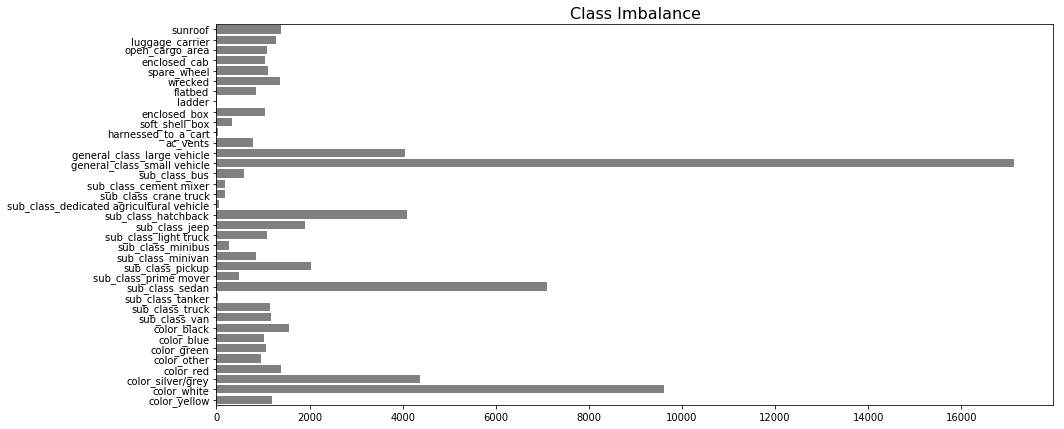

In [63]:
counts = dataset.df.drop(columns=['id'], inplace=False).sum(axis=0)

plt.figure(figsize=(15,7))
sns.barplot(x=counts.values, y=counts.index.values, color='grey')
plt.title('Class Imbalance', fontsize=16)
plt.show()

# Create Training-validation Split
Now we will create a new training-validation split, this time including the generated augmented samples.

In [65]:
train_indexes, valid_indexes = train_valid_split(dataset.df, trainsplit_size=0.8)

Number of samples in provided dataset: 11617

Split criteria
train size: 80.00 %
valid size: 20.00 %

Split results
Train size:	9281	(79.89 %)
Val size:	2336	(20.11 %)


# Define Dataloader

In [8]:
BATCH_SIZE = 64

trainsampler = SubsetRandomSampler(train_indexes)
validsampler = SubsetRandomSampler(valid_indexes)

samplers = {'train': trainsampler,
            'valid': validsampler}

trainloader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         sampler=samplers['train'],
                         num_workers=4)
validloader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         sampler=samplers['valid'],
                         num_workers=4)

dataloaders = {'train': trainloader,
               'valid': validloader}

dataset_sizes = {x: len(samplers[x]) for x in ['train', 'valid']}

# Train

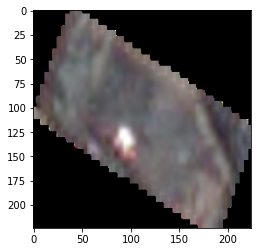

prediction was ['general_class_small vehicle']
label was ['wrecked', 'general_class_small vehicle', 'sub_class_sedan', 'color_red']


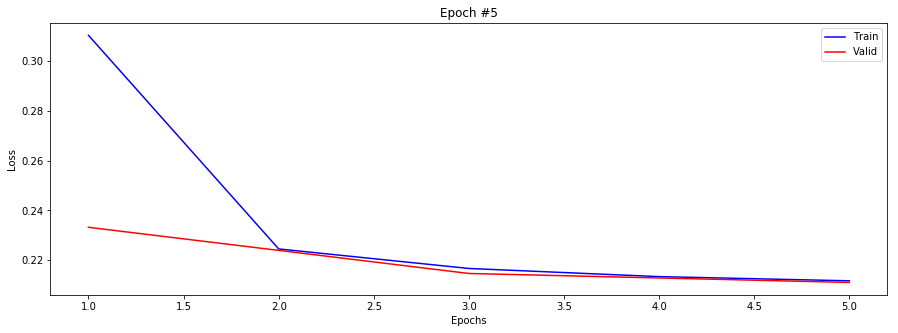

Training loss: 0.21
Validation loss:0.21	Validation MAP: 1.89

					Training time 0:05:32.530736


In [11]:
%matplotlib inline
epochs = 5
threshold = 0.5
valid_every = 2
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


losses_train = pd.DataFrame(columns=['Epoch','Loss'])
losses_valid = pd.DataFrame(columns=['Epoch','Loss'])

now = datetime.datetime.now()
picUpdate = datetime.datetime.now()

print("Using device:", device)

for epoch in range(epochs):
    batch_loss = []
   
    net.train()
    for batch in dataloaders['train']:
        inputs = batch['image'].permute(0, 3, 1, 2)
        labels = batch['targets']
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # make prediction, and do loss / backporopgation
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        
        #################### plotting ###############################
        if epoch > 0:
            if datetime.datetime.now() > picUpdate:
                pred = [dataset.df.columns[i] for i,pred in enumerate(output[0]) if pred > threshold]
                label = [dataset.df.columns[i] for i,pred in enumerate(labels[0]) if pred > threshold]
                img = inputs[0].cpu().numpy().transpose((1, -1, 0)) #transpose(1,-1,0)
                pl.imshow(img);
                pl.show()
                print("prediction was {}".format(pred))
                print("label was {}".format(label))
                picUpdate = datetime.datetime.now() + datetime.timedelta(seconds=1)
                # Plot the loss every epoch
                pl.figure(figsize=(15,5))
                pl.xlabel('Epochs')
                pl.ylabel('Loss')
                pl.title('Epoch #{}'.format(epoch+1))
                pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
                pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
                pl.legend()
                pl.show()
                print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
                print('Validation loss:{:.2f}\tValidation MAP: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy))
                display.clear_output(wait=True)
            
        else:
            if datetime.datetime.now() > picUpdate:
                pred = [dataset.df.columns[i] for i,pred in enumerate(output[0]) if pred > threshold]
                label = [dataset.df.columns[i] for i,pred in enumerate(labels[0]) if pred > threshold]
                img = inputs[0].cpu().numpy().transpose((1, -1, 0)) #transpose(1,-1,0)
                pl.imshow(img);
                pl.show()
                print("prediction was {}".format(pred))
                print("label was {}".format(label))
                picUpdate = datetime.datetime.now() + datetime.timedelta(seconds=1)
                display.clear_output(wait=True)
        #############################################################              
        
       
    losses_train.loc[epoch] = [epoch+1,np.mean(batch_loss)]
    
    if epoch%valid_every == 0 or epoch == max(range(epochs)):
        batch_loss = []
        preds = np.empty((0,37), int)
        trues = np.empty((0,37), int)
        net.eval()
        for batch in dataloaders['valid']:
            inputs = batch['image'].permute(0, 3, 1, 2)
            labels = batch['targets']
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float) 
            
            # Make prediction
            output = net(inputs)
            loss = criterion(output,labels)
            batch_loss.append(loss.item())
            
            # Append values for later calculation of accuracy
            preds = np.append(preds,[[1 if pred > threshold else 0 for pred in sample] for sample in output], axis=0)
            trues = np.append(trues,[[1 if pred > threshold else 0 for pred in sample] for sample in labels.tolist()], axis=0)
            
            
        
        losses_valid.loc[epoch] = [epoch+1,np.mean(batch_loss)]
        accuracy = MAP(preds, trues)
    
    
    #################### plotting ###############################
    pl.imshow(img);
    pl.show()
    print("prediction was {}".format(pred))
    print("label was {}".format(label))
    # Plot the loss every epoch
    pl.figure(figsize=(15,5))
    pl.xlabel('Epochs')
    pl.ylabel('Loss')
    pl.title('Epoch #{}'.format(epoch+1))
    pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
    pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
    pl.legend()
    pl.show()
    print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
    print('Validation loss:{:.2f}\tValidation MAP: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy))
    display.clear_output(wait=True)
    #############################################################

#################### plotting ###############################    
pl.imshow(img);
pl.show()
print("prediction was {}".format(pred))
print("label was {}".format(label))    
# Final plot    
pl.figure(figsize=(15,5))
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.title('Epoch #{}'.format(epoch+1))
pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
pl.legend()
pl.show()

print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
print('Validation loss:{:.2f}\tValidation MAP: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy))

print("\n\t\t\t\t\tTraining time {}".format(datetime.datetime.now()-now))
#############################################################